# LAB 3

In [11]:
from sklearn.model_selection import train_test_split
from numpy import unique
from math import inf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


def read_data(file_name):
    data = pd.read_csv(file_name)
    y = data['class']
    x = data.drop(['class'], axis=1)
    data.head()
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.34, random_state=10)
    return x_train, x_test, y_train, y_test

## ROC CLASS

In [12]:
class ROC:
    def __init__(self, probs, true_class):
        # constructor
        self.ROC_coordinates = None
        self.probs = probs
        self.true_class = true_class
        self.trap_area = lambda x1, x2, y1, y2: abs(x1 - x2) * ((y1 + y2) / 2)
        self.slope = lambda px, py, qx, qy, rx, ry: (qy - py) * (rx - qx) - (qx - px) * (ry - qy)
        self.sort()

    def __classes__(self, classes):
        # initialise positive and negative classes
        self.classes = classes
        self.P = len([n for n in self.true_class if n == self.classes[0]])
        self.N = len([n for n in self.true_class if n == self.classes[1]])

    def compute_roc_coordinates(self):
        # compute coordinates for ROC curve
        FP = 0
        TP = 0
        TPr = []
        FPr = []
        prev_prob = -inf
        for i, v in self.probs.iteritems():
            if v != prev_prob:
                TPr.append(TP / self.P)
                FPr.append(FP / self.N)
                prev_prob = v
            if self.true_class.loc[i] == self.classes[0]:
                TP = TP + 1
            else:
                FP = FP + 1
            TPr.append(TP / self.P)
            FPr.append(FP / self.N)
        self.ROC_coordinates = pd.DataFrame(data={'TPr': TPr, 'FPr': FPr})
        return self.ROC_coordinates

    def sort(self):
        # sort instances by descending probability
        # P(being positive instance)
        ds = {'probs': self.probs, 'true_class': self.true_class}
        s = pd.DataFrame(data=ds)
        s = s.sort_values(by=['probs'], ascending=False)
        self.probs = s['probs']
        self.true_class = s['true_class']

    def plot_roc(self, ty, x=None, y=None):
        # plot instance ROC points or given ones
        if x is None or y is None:
            plt.plot(self.ROC_coordinates['FPr'], self.ROC_coordinates['TPr'], ty)
            plt.xlim((0, 1))
            plt.ylim((0, 1))
            plt.xlabel(['FPr'])
            plt.ylabel(['TPr'])
            plt.show()
        else:
            plt.plot(x, y, ty)

    def compute_auc_roc(self):
        # compute area under the ROC curve
        A = 0
        FP = TP = 0
        FP_ = TP_ = 0
        prev_prob = -inf
        for i, v in self.probs.iteritems():
            if v != prev_prob:
                A = A + self.trap_area(FP, FP_, TP, TP_)
                prev_prob = v
                FP_ = FP
                TP_ = TP
            if self.true_class.loc[i] == self.classes[0]:
                TP = TP + 1
            else:
                FP = FP + 1
            A = A + self.trap_area(1, FP_, 1, TP_)
            A = A / (self.P * self.N)
        return A

    @staticmethod
    def index(px, py) -> int:
        # returns the index of the left-top most point
        m = 0
        for i in range(1, len(px)):
            if px[i] < px[m]:
                m = i
            elif px[i] == px[m]:
                if py[i] > py[m]:
                    m = i
        return m

    def compute_roc_convex_hull(self, n):
        # computes the convex hull for the ROC curve
        # excluding concavities
        l: int = self.index(self.ROC_coordinates['FPr'], self.ROC_coordinates['TPr'])
        hull_x = []
        hull_y = []
        i = l
        while True:
            hull_x.append(self.ROC_coordinates['FPr'][i])
            hull_y.append(self.ROC_coordinates['TPr'][i])
            w = (i + 1) % n
            for j in range(n):
                if self.slope(
                        self.ROC_coordinates['FPr'][i], self.ROC_coordinates['TPr'][i],
                        self.ROC_coordinates['FPr'][j], self.ROC_coordinates['TPr'][j],
                        self.ROC_coordinates['FPr'][w], self.ROC_coordinates['TPr'][w]
                ) < 0:
                    w = j
            i = w
            if i == l:
                break
        return hull_x, hull_y

    def test(self, k):
        # testing ROC curve and convex hull
        ROC_coord = self.compute_roc_coordinates()
        self.plot_roc('rv--', x=ROC_coord['FPr'], y=ROC_coord['TPr'])
        n = len(self.ROC_coordinates['TPr'])
        ROC_hull_x, ROC_hull_y = self.compute_roc_convex_hull(n)
        plt.plot(ROC_hull_x, ROC_hull_y, 'bo--')
        plt.legend(['roc curve', 'convex hull'])
        plt.title(f'ROC k: {k}, area= {self.compute_auc_roc()}')
        plt.show()

## kNN class

In [13]:
class kNN:
    def __init__(self, k=3, exp=2):
        self.s = 1e-6
        self.k = k
        self.exp = exp

    def __fit__(self, xtr, ytr):
        self.X_train = xtr
        self.Y_train = ytr

    def get_class_probs(self, X_test, Y_test):
        classes = unique(Y_test)
        probs = pd.DataFrame(data=np.zeros((len(X_test.index), len(classes))),
                             columns=classes,
                             index=X_test.index)

        for i in range(len(X_test)):
            predictions = self.predict(X_test, i)
            for x in predictions.index:
                instance = probs.iloc[i]
                instance.loc[x] = self.get_class_probability(predictions[x], len(classes))

        return pd.concat([X_test, probs], axis=1)

    def get_class_probability(self, n_instances_class_i, n_classes):

        return (n_instances_class_i + self.s) / (self.k + n_classes * self.s)

    def predict(self, X_test, i):
        distances = []
        for j in range(len(self.X_train)):  # find neighbours
            distance = self.minkowski_distance(X_test.iloc[i], self.X_train.iloc[j])
            distances.append(distance)

        df_dists = pd.DataFrame(data=distances, columns=['dist'], index=self.Y_train.index)
        df_knn = df_dists.sort_values(by=['dist'], axis=0)[:self.k]
        return self.Y_train[df_knn.index].value_counts()  # select and return the k-nearest

    def minkowski_distance(self, x1, x2):
        distance = 0
        for i in range(len(x1)):
            distance = distance + abs(x1[i] - x2[i]) ** self.exp
        distance = distance ** (1 / self.exp)
        return distance

## Testing

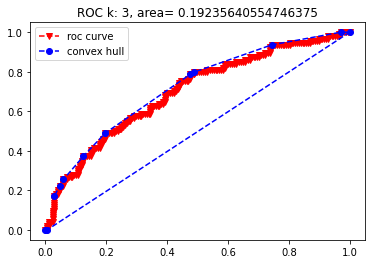

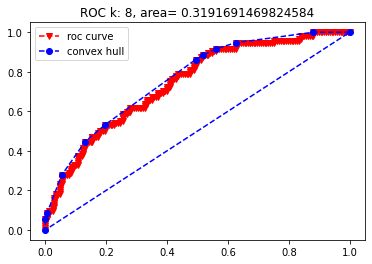

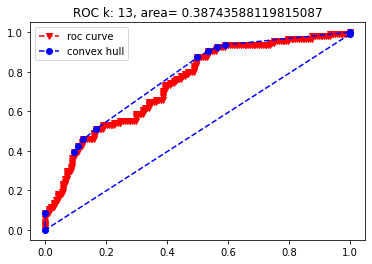

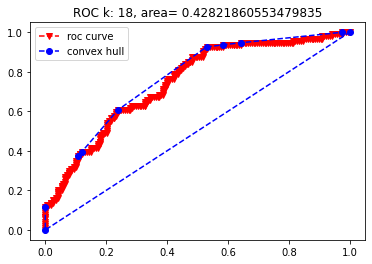

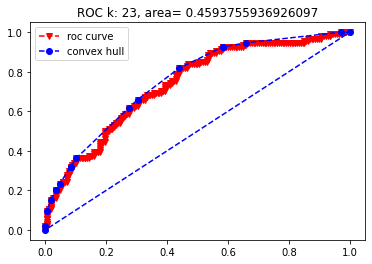

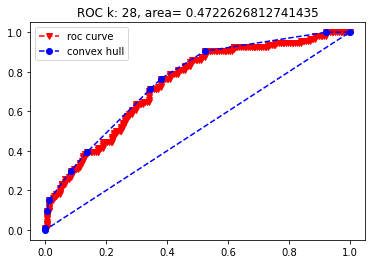

In [14]:
def test_roc(k, xtr, ytr, xt, yt):
    knn = kNN(k, 10)
    knn.__fit__(xtr, ytr)
    class_probs = knn.get_class_probs(xt, yt)
    prob = class_probs['tested_positive']
    roc = ROC(prob, yt)
    roc.__classes__(['tested_positive', 'tested_negative'])
    roc.test(k)


X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = read_data("../data/diabetes.csv")
for r in range(3, 29, 5):
    test_roc(r, X_TRAIN, Y_TRAIN, X_TEST, Y_TEST)


## Describe the strategy to handle test instances of opposite classes that have the same probability for the positive class.

The sorting in the beginning of the algorithm doesn't take
care of the ordering of instances which have the same
probability. However, depending on how they are processed
during the algorithm may affect the concavity/convexity of
the ROC curve, creating local optima or minima.
Indeed, for any instance which have the same probability as
the previous one processed, being a True Positive would place it
on the top of the previous one, when being a False Positive
would put it on the right of it.
Therefore in the given implementation the equal probability
instances are merged and averaged to get the diagonal of the
vertical or horizontal lines that would be created.
